## Libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Get Data

In [94]:
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,False,False,False,False,False,False,False


### Overview

In [95]:
n_flights = dat['weekly_flights'].sum()
operators = dat['operator'].unique()
n_operators = len(operators)
cities = list(set(dat['from'].tolist() + dat['to'].tolist()))
n_cities = len(cities)

print('In a week, %i operators run %i domestic flights into and out of %i Indian cities.\n' % 
      (n_operators, n_flights, n_cities))
print('A flight departs from and arrives into a different city, so the %i flights result in' % n_flights)
print('a weekly total of %i arrivals and departures.' % (2*n_flights))

In a week, 9 operators run 21953 domestic flights into and out of 102 Indian cities.

A flight departs from and arrives into a different city, so the 21953 flights result in
a weekly total of 43906 arrivals and departures.


### Top Cities by Traffic

<ul>
    <li>Take a slice of the dataframe that includes only relevant columns - <i>operator, from, to, weekly_flights, weekly_capacity, weekly_est_pass, from_time_slot, to_time_slot</i>.
    <li>Create a new datafram by wrangle the data slice to identify for each city, across all carriers:
        <ol>
            <li>weekly total number of flights (arrivals plus departures).
            <li>weekly capacity.
            <li>weekly estimated passengers
        </ol>
</ul>

Identify the top cities that account for 80% of all flights.

In [96]:
sdat = dat[['operator','from', 'to', 'weekly_flights', 'weekly_capacity', 'weekly_est_pass', 
            'from_time_slot', 'to_time_slot']]

weeklies_ = ['weekly_flights', 'weekly_capacity', 'weekly_est_pass']
from_flights = sdat.groupby(['from'])[weeklies_].sum()
to_flights = sdat.groupby(['to'])[weeklies_].sum()

city_weekly = pd.concat([from_flights, to_flights], axis = 1, ignore_index = True)
city_weekly = city_weekly.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or 
                                                                  # to a city, replace NA by 0
city_weekly = city_weekly.rename(columns = {0:'from_weekly_flights', 
                                            3:'to_weekly_flights',
                                            1:'from_weekly_capacity',
                                            4:'to_weekly_capacity',
                                            2:'from_weekly_est_pass',
                                            5:'to_weekly_est_pass'}, errors = 'raise')

city_weekly['total_weekly_flights'] = city_weekly.apply(lambda row: 
                                                        row.from_weekly_flights + row.to_weekly_flights,
                                                        axis = 1)
city_weekly['total_weekly_capacity'] = city_weekly.apply(lambda row: 
                                                        row.from_weekly_capacity + row.to_weekly_capacity,
                                                        axis = 1)
city_weekly['total_weekly_est_pass'] = city_weekly.apply(lambda row: 
                                                        row.from_weekly_est_pass + row.to_weekly_est_pass,
                                                        axis = 1)

city_weekly.head()

,from_weekly_flights,from_weekly_capacity,from_weekly_est_pass,to_weekly_flights,to_weekly_capacity,to_weekly_est_pass,total_weekly_flights,total_weekly_capacity,total_weekly_est_pass
AGR,4,280,218,4,280,218,8,560,436
AGX,7,490,383,7,490,383,14,980,766
AIP,7,546,500,7,546,500,14,1092,1000
AJL,11,1342,1046,24,3782,3223,35,5124,4269
AMD,764,124123,109080,750,120574,105987,1514,244697,215067


#### Top Cities by Weekly Total Arrivals and Departures

20 cities account for 80% of all arrivals and departures.

Cities accounting for 80% of all arrivals and departures:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Jaipur', 'Lucknow', 'Patna', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore', 'Coimbatore', 'Bagdogra', 'Chandigarh']


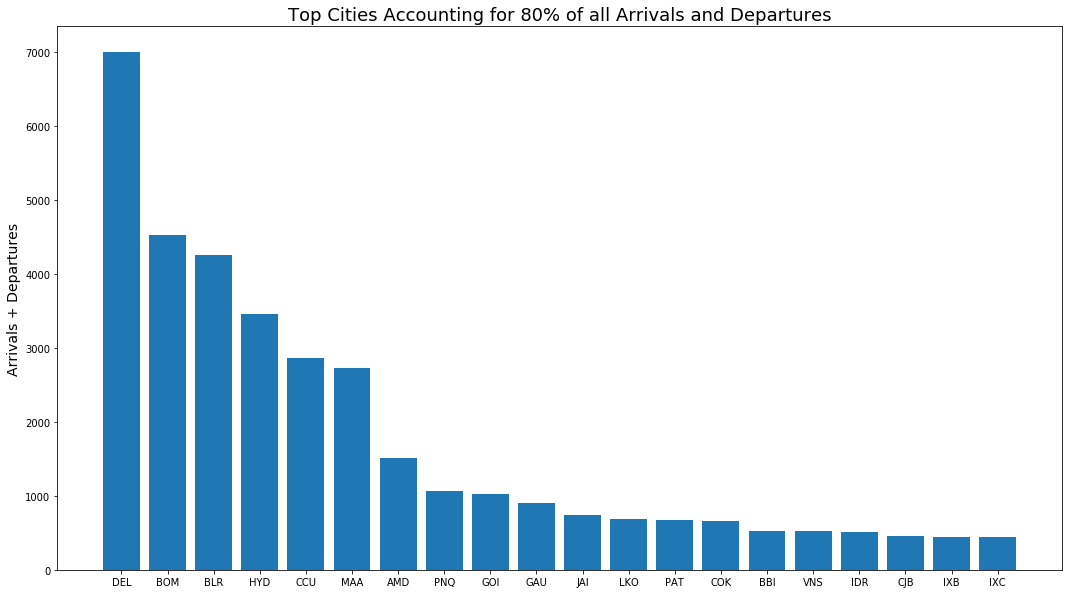

In [97]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())

city_weekly = city_weekly.sort_values(by = ['total_weekly_flights'], ascending = False)
total_ = city_weekly['total_weekly_flights'].sum()

city_weekly['%_total_weekly_flights'] = round(city_weekly['total_weekly_flights'].cumsum()/total_, 2)

top_cities_code = city_weekly.loc[city_weekly['%_total_weekly_flights'] <= 0.8, :].index.tolist()
top_cities = [codes_to_city[top_cities_code[i]] for i in range(len(top_cities_code))]

print('%i cities account for 80%% of all arrivals and departures.\n' % len(top_cities_code))
print('Cities accounting for 80% of all arrivals and departures:\n', top_cities)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, city_weekly['total_weekly_flights'][0:len(top_cities)])
plt.title('Top Cities Accounting for 80% of all Arrivals and Departures', size = 18)
plt.ylabel('Arrivals + Departures', size = 14)
plt.show()

#### Top Cities by Weekly Total Capacity

17 cities account for 80% of total weekly capacity.

Cities accounting for 80% of total weekly capacity:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Indore', 'Varanasi']


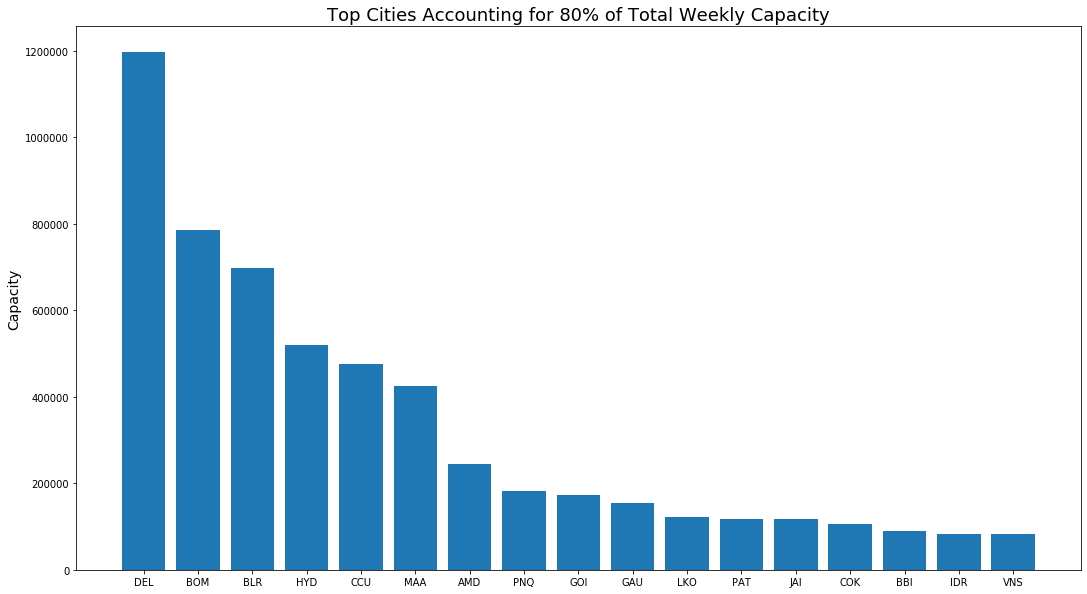

In [98]:
city_weekly = city_weekly.sort_values(by = ['total_weekly_capacity'], ascending = False)
total_ = city_weekly['total_weekly_capacity'].sum()

city_weekly['%_total_weekly_capacity'] = round(city_weekly['total_weekly_capacity'].cumsum()/total_, 2)

top_cities_code = city_weekly.loc[city_weekly['%_total_weekly_capacity'] <= 0.8, :].index.tolist()
top_cities = [codes_to_city[top_cities_code[i]] for i in range(len(top_cities_code))]

print('%i cities account for 80%% of total weekly capacity.\n' % len(top_cities_code))
print('Cities accounting for 80% of total weekly capacity:\n', top_cities)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, city_weekly['total_weekly_capacity'][0:len(top_cities)])
plt.title('Top Cities Accounting for 80% of Total Weekly Capacity', size = 18)
plt.ylabel('Capacity', size = 14)
plt.show()

#### Top Cities by Weekly Total Estimated Passengers

17 cities account for 80% of total estimated weekly passengers.

Cities accounting for 80% of total estimated weekly passengers:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore']


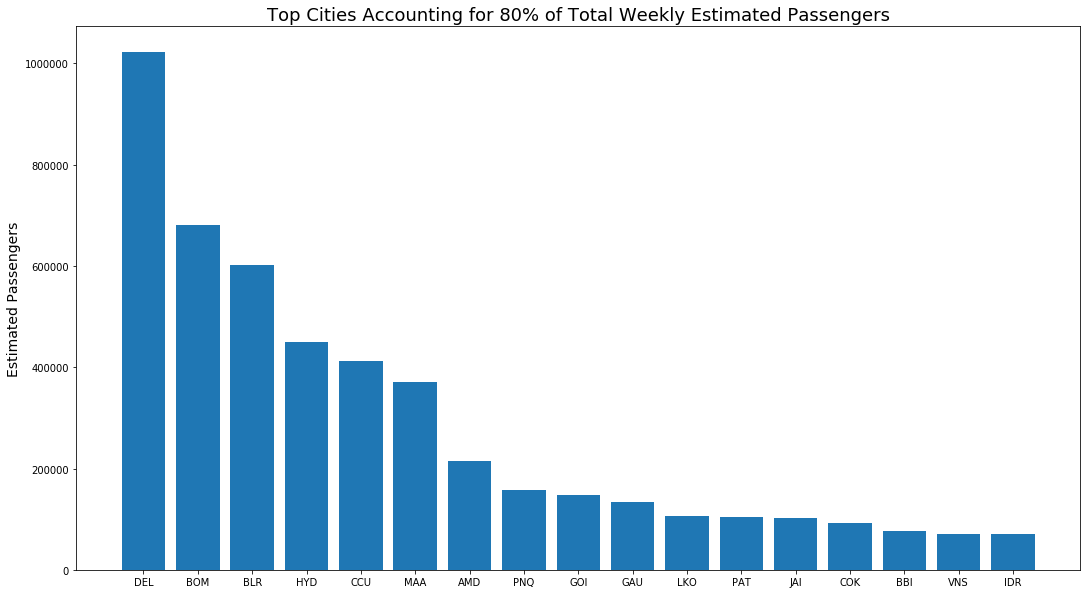

In [99]:
city_weekly = city_weekly.sort_values(by = ['total_weekly_est_pass'], ascending = False)
total_ = city_weekly['total_weekly_est_pass'].sum()

city_weekly['%_total_weekly_est_pass'] = round(city_weekly['total_weekly_est_pass'].cumsum()/total_, 2)

top_cities_code = city_weekly.loc[city_weekly['%_total_weekly_est_pass'] <= 0.8, :].index.tolist()
top_cities = [codes_to_city[top_cities_code[i]] for i in range(len(top_cities_code))]

print('%i cities account for 80%% of total estimated weekly passengers.\n' % len(top_cities_code))
print('Cities accounting for 80% of total estimated weekly passengers:\n', top_cities)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, city_weekly['total_weekly_est_pass'][0:len(top_cities)])
plt.title('Top Cities Accounting for 80% of Total Weekly Estimated Passengers', size = 18)
plt.ylabel('Estimated Passengers', size = 14)
plt.show()

In [108]:
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,False,False,False,False,False,False,False
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,False,False,False,False,False,False,False


In [109]:
city_codes = ['BLR']
idx = [i for i in range(dat.shape[0]) if dat['from'][i] in city_codes or dat['to'][i] in city_codes]
sdat = dat.iloc[idx, :]
sdat.groupby(['from'])['weekly_flights'].sum()

from
AGX       7
AMD      63
ATQ       7
BBI      53
BDQ      14
BHO       7
BLR    2139
BOM     256
CCJ      14
CCU     118
CJB      39
CNN      19
COK      56
DED       6
DEL     261
GAU      31
GOI      68
GOP       7
GWL       6
HBX      21
HYD     188
IDR      20
IMF       7
IXA       7
IXB      21
IXC      19
IXD       7
IXE      68
IXG      29
IXM      26
IXR      21
IXZ      14
JAI      40
JDH       7
JSA       7
KLH       7
LKO      39
MAA     123
MYQ       7
NAG      28
PAT      39
PNQ     111
PNY       6
RJA      14
RPR      14
SAG      12
STV      14
TCR       7
TIR       7
TRV      45
TRZ       7
UDR       7
VDY       7
VGA      34
VNS      26
VTZ      34
Name: weekly_flights, dtype: int64